# YouTube Comment Cleaning and Exploration

Takes data from a CSV file and cleans the data to isolate comments of interest

In [1]:
import re
import japanize_matplotlib
import matplotlib.pyplot as plt
import nagisa
import numpy as np
import pandas as pd
import seaborn as sns

from collections import Counter
from functools import reduce
from operator import add
from pathlib import Path

NumExpr defaulting to 8 threads.


In [2]:
input_path = Path('Resources/youtube_comments.csv')
comments_df = pd.read_csv(input_path, index_col=0)

comments_df.head(10)

,channel,video_id,category_id,text,date_published,comment_type
0,mwamjapan,Jb6Zlg30rgk,10,This season is going to be a masterpiece <3,2023-04-16T15:39:10Z,top-level
1,mwamjapan,Jb6Zlg30rgk,10,Every season is masterpiece 🔥🔥🔥,2023-04-17T16:41:52Z,reply
2,mwamjapan,Jb6Zlg30rgk,10,@HM cry about it,2023-04-17T16:15:19Z,reply
3,mwamjapan,Jb6Zlg30rgk,10,@HM dude demon slayer has no story but it has ...,2023-04-17T15:44:29Z,reply
4,mwamjapan,Jb6Zlg30rgk,10,@HM 🙂🙃😒😒😒,2023-04-17T13:44:05Z,reply
5,mwamjapan,Jb6Zlg30rgk,10,Honestamente no entiendo porqué esta canción r...,2023-04-17T03:58:25Z,top-level
6,mwamjapan,Jb6Zlg30rgk,10,​@みっくん𓈒𓂂◌𝙼𝙸𝚈𝚄 llora pues,2023-04-17T17:15:35Z,reply
7,mwamjapan,Jb6Zlg30rgk,10,たかがOPで世界観が壊れるアニメじゃないわはげたこ,2023-04-17T16:00:09Z,reply
8,mwamjapan,Jb6Zlg30rgk,10,悩めば、イイ！,2023-04-17T14:53:19Z,reply
9,mwamjapan,Jb6Zlg30rgk,10,@みっくん𓈒𓂂◌𝙼𝙸𝚈𝚄 ニワカほどそう言うよね！,2023-04-17T13:11:13Z,reply


In [3]:
# RE patterns needed for JP text
hiragana = r'\u3041-\u3096'
katakana = r'\u30A1-\u30F6'
kanji = r'\u3006\u4E00-\u9FFF'

# Matches to test for existence of text that uses a Japanese script
jp_text = rf'[{hiragana}{katakana}{kanji}]'

# Accepted characters
accepted_char = rf'[a-zA-Z0-9\u30FC\u3005{hiragana}{katakana}{kanji}]'

In [4]:
# Remove @username from replies
# Done before rest of cleaning to ensure a user using a Japanese script doesn't pass filter
comments_df['text'] = comments_df['text'].str.replace(r'@\S+\s', '', regex=True)

In [5]:
# Filter out comments that don't have any Japanese characters
has_jp_char = comments_df.loc[comments_df['text'].str.contains(jp_text, regex=True)]

has_jp_char.sample(10)

,channel,video_id,category_id,text,date_published,comment_type
16,ベーコン家のポテとひだり,1FK4rh7iOWs,15,チャーくんの初めてのお散歩はパパさん✨ママさんのドキドキとチャーくんもどキドキドだつたね🐶ポ...,2023-04-12T20:58:03Z,top-level
97,プレチャン 【プレミアリーグ情報チャンネル】,j9gZfR3j6cU,17,ウンパルンパは自分が誹謗中傷されたら棚に上げるのに自分はリゼムと一緒になって人いじめて中傷す...,2023-04-13T12:51:06Z,reply
127,【Repezen Foxx】,T66f7NlxdTQ,23,聞いたの初めてじゃないけど\nリミックスになって\nMV鳥肌たった😮🎉🎉\nかっこいい❤❤,2023-04-16T11:56:53Z,top-level
34,ベーコン家のポテとひだり,1FK4rh7iOWs,15,ずっと涙しながら見てました\nポッちゃんひだちゃん\nそしてパパさんママさんの\n愛情たっぷ...,2023-04-13T07:15:44Z,top-level
141,KADOKAWAanime,ThmEKGQC_s8,1,この5人が揃うのは熱すぎる！,2023-04-15T12:12:54Z,top-level
79,Snow Man,5-iJl-fKHwI,10,最後に「あいことば」という歌詞を届けるのが岩本くんなのマジで泣ける,2023-04-17T09:43:47Z,top-level
46,有吉の壁【公式】壁チャンネル,xQTd08X7cjY,23,大水さん出てきただけでも笑っちゃうから有吉の壁で見れるの楽しみだ,2023-04-13T10:04:39Z,top-level
85,トレバー・バウアー,9tazyKRmaZw,17,マジで1から10までプレーを理論化して、それを基にトレーニングや調整してるの凄すぎる！自分の...,2023-04-17T01:39:27Z,top-level
116,きまぐれクックのサボり場,HDIaYU5WaMQ,26,浜辺ミナミちゃんの流、出ハ✖️鳥見たいってことぉ？？？\n中ﾀﾞ市が止まらないぃぃぃぃぃ！！...,2023-04-14T11:37:51Z,reply
56,塚原農園,zC3D7OAlm84,26,フラガールは甘さが良く分かる品種で人気がありますね。皮の柔らかさではプチぷよ、糖度ではオラン...,2023-04-12T14:16:09Z,reply


In [6]:
# Remove other unnecessary characters - 
def clean_text(text):
    
    text = re.sub(r'\n', '', text)
    text = re.sub(r'\t', '', text)
    text = re.sub(r'\r', '', text)
    text = re.sub(r'https?://[a-zA-Z0-9.-]*[/?[a-zA-Z0-9.-_]*]*', '', text)
    text = re.sub(r'笑+', '笑', text)
    
    filtered_text = ''
    
    for char in text:
        if re.match(accepted_char, char):
            
            filtered_text += char
            
    return filtered_text

In [7]:
# Clean
cleaned_df = has_jp_char.copy()
cleaned_df['text'] = cleaned_df['text'].apply(clean_text)

cleaned_df.head(10)

,channel,video_id,category_id,text,date_published,comment_type
7,mwamjapan,Jb6Zlg30rgk,10,たかがOPで世界観が壊れるアニメじゃないわはげたこ,2023-04-17T16:00:09Z,reply
8,mwamjapan,Jb6Zlg30rgk,10,悩めばイイ,2023-04-17T14:53:19Z,reply
9,mwamjapan,Jb6Zlg30rgk,10,ニワカほどそう言うよね,2023-04-17T13:11:13Z,reply
18,mwamjapan,Jb6Zlg30rgk,10,珍しくショート動画が出てますね最高すぎる,2023-04-17T10:49:06Z,reply
19,mwamjapan,Jb6Zlg30rgk,10,めっちゃ同意,2023-04-17T08:30:39Z,reply
44,mwamjapan,Jb6Zlg30rgk,10,miletとのコラボには最初びっくりしたけど声の相性が良くて特に重なった時に何とも言えない不...,2023-04-17T00:54:46Z,top-level
45,mwamjapan,Jb6Zlg30rgk,10,全く仰るとおりで作中にはいろんな絆ノ奇跡がありますよね特に刀鍛冶の里編のラストは絆ノ奇跡その...,2023-04-17T13:48:13Z,reply
46,mwamjapan,Jb6Zlg30rgk,10,我が命果てようとも繋いでいこう自分が志半ばで死んでも繋いだ命がきっと果たしてくれると二話で炭...,2023-04-17T13:37:24Z,reply
47,mwamjapan,Jb6Zlg30rgk,10,我が命果てようともには無一郎を思い浮かべました,2023-04-17T13:07:22Z,reply
48,mwamjapan,Jb6Zlg30rgk,10,鬼滅の刃には色んな絆ノ奇跡がありますね,2023-04-17T11:53:14Z,reply


In [8]:
# Check size of DF
cleaned_df.shape

(11297, 6)

In [9]:
# Check for null values
cleaned_df.isna().sum()

channel           0
video_id          0
category_id       0
text              0
date_published    0
comment_type      0
dtype: int64

In [10]:
# Check unique values in each
cleaned_df.nunique()

channel              82
video_id             92
category_id          12
text              10659
date_published    11104
comment_type          2
dtype: int64

In [11]:
# Check amounts of top-level vs. replies for comments
cleaned_df['comment_type'].value_counts()

top-level    8320
reply        2977
Name: comment_type, dtype: int64

In [12]:
# Tokenize text
analysis_df = cleaned_df.copy()
analysis_df['tokens'] = analysis_df['text'].apply(lambda x: nagisa.tagging(x))

analysis_df.head(10)

,channel,video_id,category_id,text,date_published,comment_type,tokens
7,mwamjapan,Jb6Zlg30rgk,10,たかがOPで世界観が壊れるアニメじゃないわはげたこ,2023-04-17T16:00:09Z,reply,たか/名詞 が/助詞 OP/名詞 で/助詞 世界/名詞 観/接尾辞 が/助詞 壊れる/動詞 ...
8,mwamjapan,Jb6Zlg30rgk,10,悩めばイイ,2023-04-17T14:53:19Z,reply,悩め/動詞 ば/助詞 イイ/形容詞
9,mwamjapan,Jb6Zlg30rgk,10,ニワカほどそう言うよね,2023-04-17T13:11:13Z,reply,ニワカ/形状詞 ほど/助詞 そう/副詞 言う/動詞 よ/助詞 ね/助詞
18,mwamjapan,Jb6Zlg30rgk,10,珍しくショート動画が出てますね最高すぎる,2023-04-17T10:49:06Z,reply,珍しく/形容詞 ショート/名詞 動画/名詞 が/助詞 出/動詞 て/助動詞 ます/助動詞 ね...
19,mwamjapan,Jb6Zlg30rgk,10,めっちゃ同意,2023-04-17T08:30:39Z,reply,めっちゃ/副詞 同意/名詞
44,mwamjapan,Jb6Zlg30rgk,10,miletとのコラボには最初びっくりしたけど声の相性が良くて特に重なった時に何とも言えない不...,2023-04-17T00:54:46Z,top-level,milet/名詞 と/助詞 の/助詞 コラボ/名詞 に/助詞 は/助詞 最初/名詞 びっくり...
45,mwamjapan,Jb6Zlg30rgk,10,全く仰るとおりで作中にはいろんな絆ノ奇跡がありますよね特に刀鍛冶の里編のラストは絆ノ奇跡その...,2023-04-17T13:48:13Z,reply,全く/副詞 仰る/動詞 とおり/名詞 で/助詞 作中/名詞 に/助詞 は/助詞 いろんな/連...
46,mwamjapan,Jb6Zlg30rgk,10,我が命果てようとも繋いでいこう自分が志半ばで死んでも繋いだ命がきっと果たしてくれると二話で炭...,2023-04-17T13:37:24Z,reply,我が/連体詞 命/名詞 果てよう/動詞 と/助詞 も/助詞 繋い/動詞 で/助詞 いこう/動...
47,mwamjapan,Jb6Zlg30rgk,10,我が命果てようともには無一郎を思い浮かべました,2023-04-17T13:07:22Z,reply,我が/連体詞 命/名詞 果てよう/動詞 とも/名詞 に/助詞 は/助詞 無一郎/名詞 を/助...
48,mwamjapan,Jb6Zlg30rgk,10,鬼滅の刃には色んな絆ノ奇跡がありますね,2023-04-17T11:53:14Z,reply,鬼滅/名詞 の/助詞 刃/名詞 に/助詞 は/助詞 色んな/連体詞 絆ノ/名詞 奇跡/名詞 ...


In [13]:
# Created filtered column
analysis_df['filtered_tokens'] = (analysis_df['text']
                                  .apply(lambda x: nagisa.filter(x, filter_postags=['助詞', '助動詞'])))

analysis_df.head(10)

,channel,video_id,category_id,text,date_published,comment_type,tokens,filtered_tokens
7,mwamjapan,Jb6Zlg30rgk,10,たかがOPで世界観が壊れるアニメじゃないわはげたこ,2023-04-17T16:00:09Z,reply,たか/名詞 が/助詞 OP/名詞 で/助詞 世界/名詞 観/接尾辞 が/助詞 壊れる/動詞 ...,たか/名詞 OP/名詞 世界/名詞 観/接尾辞 壊れる/動詞 アニメ/名詞 ない/形容詞 は...
8,mwamjapan,Jb6Zlg30rgk,10,悩めばイイ,2023-04-17T14:53:19Z,reply,悩め/動詞 ば/助詞 イイ/形容詞,悩め/動詞 イイ/形容詞
9,mwamjapan,Jb6Zlg30rgk,10,ニワカほどそう言うよね,2023-04-17T13:11:13Z,reply,ニワカ/形状詞 ほど/助詞 そう/副詞 言う/動詞 よ/助詞 ね/助詞,ニワカ/形状詞 そう/副詞 言う/動詞
18,mwamjapan,Jb6Zlg30rgk,10,珍しくショート動画が出てますね最高すぎる,2023-04-17T10:49:06Z,reply,珍しく/形容詞 ショート/名詞 動画/名詞 が/助詞 出/動詞 て/助動詞 ます/助動詞 ね...,珍しく/形容詞 ショート/名詞 動画/名詞 出/動詞 最高/名詞 すぎる/動詞
19,mwamjapan,Jb6Zlg30rgk,10,めっちゃ同意,2023-04-17T08:30:39Z,reply,めっちゃ/副詞 同意/名詞,めっちゃ/副詞 同意/名詞
44,mwamjapan,Jb6Zlg30rgk,10,miletとのコラボには最初びっくりしたけど声の相性が良くて特に重なった時に何とも言えない不...,2023-04-17T00:54:46Z,top-level,milet/名詞 と/助詞 の/助詞 コラボ/名詞 に/助詞 は/助詞 最初/名詞 びっくり...,milet/名詞 コラボ/名詞 最初/名詞 びっくり/名詞 し/動詞 声/名詞 相性/名詞 ...
45,mwamjapan,Jb6Zlg30rgk,10,全く仰るとおりで作中にはいろんな絆ノ奇跡がありますよね特に刀鍛冶の里編のラストは絆ノ奇跡その...,2023-04-17T13:48:13Z,reply,全く/副詞 仰る/動詞 とおり/名詞 で/助詞 作中/名詞 に/助詞 は/助詞 いろんな/連...,全く/副詞 仰る/動詞 とおり/名詞 作中/名詞 いろんな/連体詞 絆ノ/名詞 奇跡/名詞 ...
46,mwamjapan,Jb6Zlg30rgk,10,我が命果てようとも繋いでいこう自分が志半ばで死んでも繋いだ命がきっと果たしてくれると二話で炭...,2023-04-17T13:37:24Z,reply,我が/連体詞 命/名詞 果てよう/動詞 と/助詞 も/助詞 繋い/動詞 で/助詞 いこう/動...,我が/連体詞 命/名詞 果てよう/動詞 繋い/動詞 いこう/動詞 自分/名詞 志/名詞 半ば...
47,mwamjapan,Jb6Zlg30rgk,10,我が命果てようともには無一郎を思い浮かべました,2023-04-17T13:07:22Z,reply,我が/連体詞 命/名詞 果てよう/動詞 とも/名詞 に/助詞 は/助詞 無一郎/名詞 を/助...,我が/連体詞 命/名詞 果てよう/動詞 とも/名詞 無一郎/名詞 思い浮かべ/動詞
48,mwamjapan,Jb6Zlg30rgk,10,鬼滅の刃には色んな絆ノ奇跡がありますね,2023-04-17T11:53:14Z,reply,鬼滅/名詞 の/助詞 刃/名詞 に/助詞 は/助詞 色んな/連体詞 絆ノ/名詞 奇跡/名詞 ...,鬼滅/名詞 刃/名詞 色んな/連体詞 絆ノ/名詞 奇跡/名詞 あり/動詞


In [14]:
# Use for examining properties of the tokens
test = analysis_df.iloc[0]['filtered_tokens']
test

In [15]:
test.words

['たか', 'OP', '世界', '観', '壊れる', 'アニメ', 'ない', 'はげ', 'たこ']

In [16]:
type(test.words[0])

str

In [17]:
str(test)

'たか/名詞 OP/名詞 世界/名詞 観/接尾辞 壊れる/動詞 アニメ/名詞 ない/形容詞 はげ/名詞 たこ/名詞'

In [18]:
# Extract filtered_tokens into a list
def extract_tokens(df_column):

    token_list = df_column.apply(lambda x: str(x).split()).tolist()
    word_list = reduce(add, token_list)
    
    return word_list

word_list = extract_tokens(analysis_df['filtered_tokens'])

In [19]:
# Get total word count and examine sample of the list
total_words = len(word_list)
print(total_words, word_list[:10])

163992 ['たか/名詞', 'OP/名詞', '世界/名詞', '観/接尾辞', '壊れる/動詞', 'アニメ/名詞', 'ない/形容詞', 'はげ/名詞', 'たこ/名詞', '悩め/動詞']


In [20]:
# Count and sort by occurrences, display as a DF
def count_words(word_list):
    
    counter = Counter(word_list)
    freq_list = counter.most_common()
    
    return freq_list

In [21]:
# Organize data as a DF display
def display_freq(freq_list):
    
    freq_df = pd.DataFrame.from_records(list(dict(freq_list).items()),
                                        columns=['word', 'count'])
    freq_df[['word', 'pos']] = freq_df['word'].str.split('/', expand=True)
    freq_df = freq_df[['word', 'pos', 'count']]
    
    return freq_df

## Frequency for entire dataset

Outside of particles, auxiliary verbs and roman digits the count of all unique words is considered - including very common words like する as well as internet colloquialisms such as w (indicates laughter similar to "lol").
Data is sorted into the most common words for the dataset in descending order. 

In [22]:
# Calculating totals for entire dataset
freq_list = count_words(word_list)
freq_df = display_freq(freq_list)

freq_df.head(10)

,word,pos,count
0,し,動詞,3578
1,1,名詞,2347
2,さん,接尾辞,2149
3,0,名詞,2094
4,2,名詞,1848
5,3,名詞,1492
6,お,接頭辞,1439
7,5,名詞,1255
8,4,名詞,1204
9,ちゃん,接尾辞,1182


In [23]:
# Remove numbers from words - this data is uninteresting
freq_df = freq_df.loc[~freq_df['word'].str.contains('\d+')].reset_index(drop=True)

freq_df.head(25)

,word,pos,count
0,し,動詞,3578
1,さん,接尾辞,2149
2,お,接頭辞,1439
3,ちゃん,接尾辞,1182
4,見,動詞,1096
5,この,連体詞,844
6,ありがとう,感動詞,813
7,いい,形容詞,796
8,好き,形状詞,788
9,ない,形容詞,786


In [24]:
freq_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17523 entries, 0 to 17522
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   word    17523 non-null  object
 1   pos     17523 non-null  object
 2   count   17523 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 410.8+ KB


In [25]:
def get_percentages(freq_df):
    
    total_words = sum(freq_df['count'])
    freq_df['freq_percentage'] = freq_df['count'] / total_words
    
    return freq_df

In [26]:
freq_df = get_percentages(freq_df)

freq_df.head(25)

,word,pos,count,freq_percentage
0,し,動詞,3578,0.023613
1,さん,接尾辞,2149,0.014182
2,お,接頭辞,1439,0.009497
3,ちゃん,接尾辞,1182,0.007800
4,見,動詞,1096,0.007233
5,この,連体詞,844,0.005570
6,ありがとう,感動詞,813,0.005365
7,いい,形容詞,796,0.005253
8,好き,形状詞,788,0.005200
9,ない,形容詞,786,0.005187


In [31]:
# Summary stats
freq_df.describe()

,count,freq_percentage
count,17523.000000,17523.000000
mean,8.647435,0.000057
std,50.010851,0.000330
min,1.000000,0.000007
25%,1.000000,0.000007
50%,1.000000,0.000007
75%,4.000000,0.000026
max,3578.000000,0.023613


In [27]:
# Examine breakdown of each POS
parts_of_speech = freq_df.groupby('pos').agg(
    unique_terms = ('word', 'count'),
    total = ('count', 'sum'),
    percent = ('freq_percentage', 'sum'))

# Sort the result
parts_of_speech = (parts_of_speech.reset_index()
                       .sort_values(['total'], ascending=False)
                       .set_index(['pos']))

parts_of_speech

,unique_terms,total,percent
pos,,,
名詞,11099,72227,0.476655
動詞,3299,35547,0.234589
形容詞,625,10643,0.070237
接尾辞,385,9980,0.065862
副詞,580,6560,0.043292
形状詞,414,5406,0.035676
代名詞,84,3420,0.022570
接頭辞,83,2468,0.016287
連体詞,33,1854,0.012235


### Plotting frequency

Uses multiple bar charts using subplots to visualize top 100 most used words - idea and code is adapted from Boriharn K from Towards Data Science

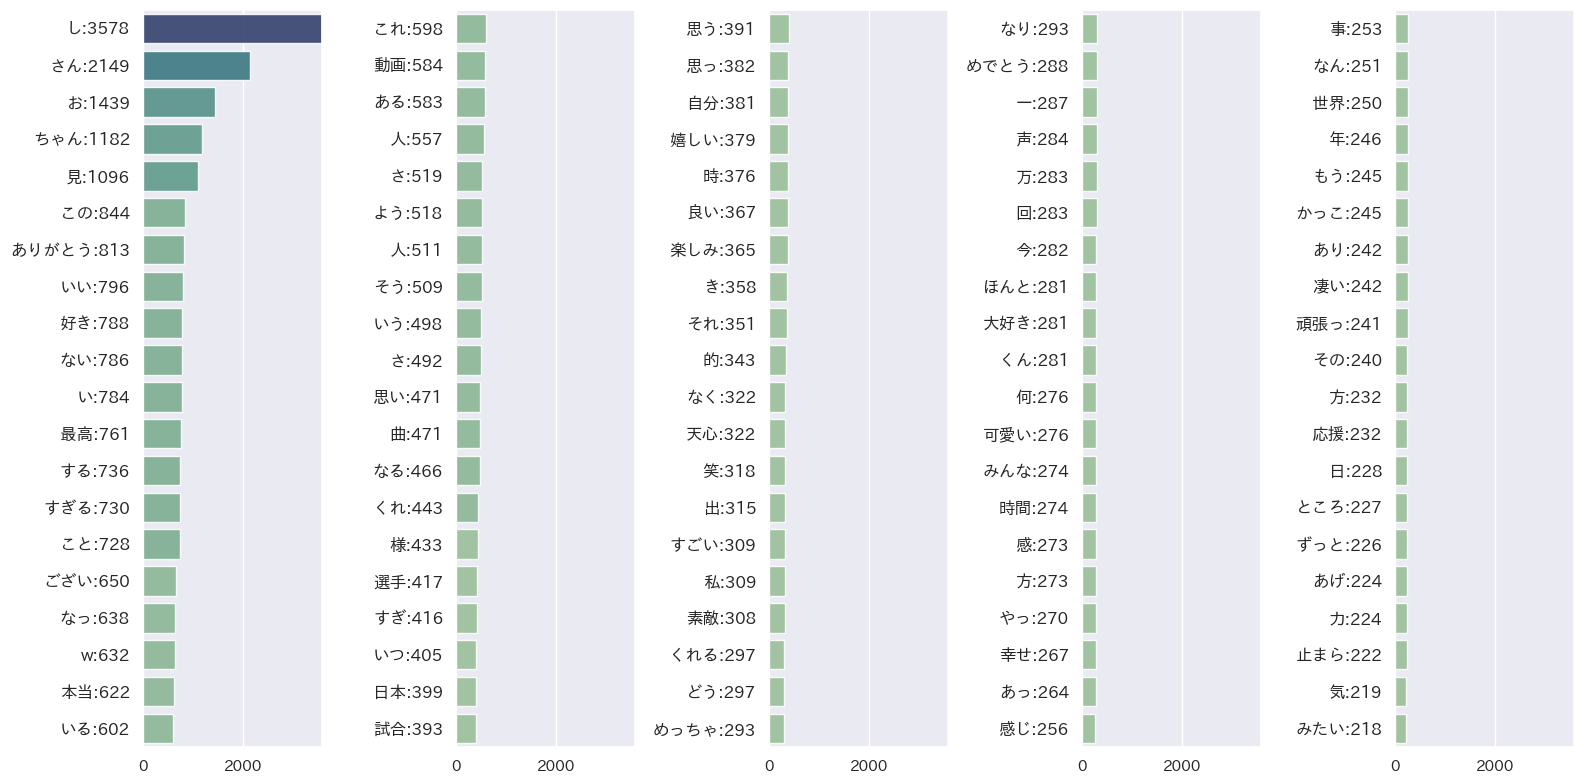

In [115]:
# Split DF into 5 equal sections
# And make a list of the start and end indices for each subsection
index_list = [[i[0], i[-1] + 1] for i in np.array_split(range(100), 5)]
max_val, min_val = freq_df['count'].max(), freq_df.iloc[99]['count']

fig, axs = plt.subplots(1, 5, figsize=(16, 8))
sns.set(font='IPAexGothic')

# Create a dictionary for color mappings
scaled_count = freq_df.iloc[0:99]['count'] // min_val
pal = list(sns.color_palette(palette='crest',
                             n_colors=scaled_count.max()).as_hex())
color_dict = dict(enumerate(pal, 1))

for col, i in enumerate(index_list):
    df = freq_df.iloc[i[0]:i[-1]]
    label = [f'{word}:{count}' for word, count in zip(df['word'], df['count'])]
    colors = [color_dict.get(val // min_val) for val in df['count']]
    x = list(df['count'])
    y = list(range(20))

    sns.barplot(x=x, y=y, alpha=0.9, orient='h',
               ax=axs[col], palette=colors)
    axs[col].set_xlim(0, max_val + 1)
    axs[col].set_yticklabels(label, fontsize=12)

plt.tight_layout()
plt.show()